In [26]:
import os
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, plotly.express as px, plotly.graph_objects as go
import datetime

In [2]:
from IPython.display import display, HTML

In [3]:
#http://www.sidc.be/silso/datafiles

In [4]:
from statsmodels.graphics.tsaplots import plot_acf

In [5]:
pd.set_option('display.max_rows',500)
sns.set(rc={'figure.figsize':(10,6)})

In [6]:
today = datetime.datetime.today()

In [7]:
sunspot = pd.read_csv('Datasets/sunspots-SN_d_tot_V2.0.csv',delimiter=';',names=['year','month','day','fractional_date','daily_sunspots','stDev','#observations','definitive'])

In [8]:
#-1 - missing value for Daily Sunspots
#For Definitive/Provisional indicator, '1' indicates that the value is definitive. '0' indicates that the value is still provisional.

In [9]:
sunspot.tail(10)

,year,month,day,fractional_date,daily_sunspots,stDev,#observations,definitive
73890,2020,4,21,2020.305,0,0.0,37,0
73891,2020,4,22,2020.307,0,0.0,43,0
73892,2020,4,23,2020.310,0,0.0,43,0
73893,2020,4,24,2020.313,0,0.0,42,0
73894,2020,4,25,2020.316,6,0.4,22,0
73895,2020,4,26,2020.318,14,1.0,23,0
73896,2020,4,27,2020.321,29,2.0,20,0
73897,2020,4,28,2020.324,15,2.6,18,0
73898,2020,4,29,2020.327,24,1.6,22,0
73899,2020,4,30,2020.329,20,1.2,20,0


In [10]:
sunspot.definitive.value_counts()

1    73779
0      121
Name: definitive, dtype: int64

In [11]:
sunspot['date'] = pd.to_datetime((sunspot['year'].astype(str)+sunspot['month'].astype(str)+sunspot['day'].astype(str)),format='%Y%m%d',errors='coerce')

In [12]:
sunspot['obs_var'] = sunspot['stDev']*sunspot['stDev']

In [13]:
sunspot['daily_sunspot_var'] = sunspot['daily_sunspots'] - sunspot['daily_sunspots'].mean()

In [14]:
sunspot['daily_sunspot_var_abs'] = abs(sunspot['daily_sunspots'] - sunspot['daily_sunspots'].mean())

In [15]:
#sunspot = sunspot.loc[sunspot['date']<=today] # remove some incorrect dates

In [16]:
fig = px.scatter(sunspot, x='date', y='daily_sunspots',width=1200, height=600)
fig.show()

In [17]:
acf = pd.concat([sunspot['date'].dt.strftime('%Y-%m-%d'),sunspot['daily_sunspots']],axis=1)

In [18]:
#fig = px.scatter(sunspot, x='date', y='stDev',width=1200, height=600)
#fig.show()

In [19]:
from helper import *

In [20]:
@timer
def autocorrelation(timelist,lags):
    #lag of one period
    
    temp2 = []

    for lag in range(lags):

        temp1 = pd.DataFrame()
        temp1 = timelist.copy()

        val_mean = temp1.iloc[:,1].mean()

        colname_lag = 'date-{}'.format(lag+1)
        temp1[colname_lag] = temp1.iloc[:,1].shift(periods=lag+1)

        colname_mean_diff = 'mean_diff-{}'.format(lag+1)
        temp1[colname_mean_diff] = temp1.iloc[:,1] - val_mean

        colname_lag_mean_diff = 'lag_mean_diff-{}'.format(lag+1)
        temp1[colname_lag_mean_diff] = temp1[colname_lag] - val_mean

        colname_square_diff = 'mean_square_diff-{}'.format(lag+1)
        temp1[colname_square_diff] = temp1[colname_mean_diff]*temp1[colname_mean_diff]

        colname_autocov = 'autocov-{}'.format(lag+1)
        temp1[colname_autocov] = temp1[colname_mean_diff]*temp1[colname_lag_mean_diff]


                 
       # print(sum(temp1[colname_autocov]))

        temp2.append(temp1[colname_autocov].sum()/temp1[colname_square_diff].sum())

    #display(HTML(temp1.tail(10).to_html()))

  #  print(temp1.head())
    
    temp2 = pd.DataFrame(temp2,columns =['autc'])

    return(temp2)

In [21]:
autc = autocorrelation(acf,10000)

Finished 'autocorrelation' in 73.0784 secs


In [74]:
autc['lag'] = range(10000)
#autc['lag'] = autc['lag']+1

In [85]:
autc['upper_bound']  =z95* np.sqrt( (1/len(autc)) * (1 + 2*((autc['lag'])^2) )  ) # z95/np.sqrt(-autc['lag'])

In [76]:
autc

,autc,lag,upper_bound
0,0.903869,0,0.022361
1,0.863933,1,0.026458
2,0.828735,2,0.010000
3,0.795061,3,0.017321
4,0.762701,4,0.036056
...,...,...,...
9995,-0.332013,9995,1.413754
9996,-0.332638,9996,1.414107
9997,-0.331537,9997,1.414178
9998,-0.331520,9998,1.413966


In [57]:
z95 = 1.959963984540054
z99 = 2.5758293035489004

In [87]:
fig = px.scatter(autc,x=autc.index,y='autc',
                        labels = {'x':'Lag'},
                        width=1800)

fig.update_layout(
    title="Correlogram for Sunspot Activity",
    xaxis_title="Lag(days)",
    yaxis_title="ACF",
)

n = len(autc)

fig.add_shape(
        # Line Horizontal
            type="line",
            x0=0,
            y0=z99/ np.sqrt(n),
            x1=n,
            y1=z99/ np.sqrt(n),
            line=dict(
                color="LightSeaGreen",
                width=2,
                dash="dashdot",
            )
    )
fig.add_shape(
        # Line Horizontal
            type="line",
            x0=0,
            y0=-z99/ np.sqrt(n),
            x1=n,
            y1=-z99/ np.sqrt(n),
            line=dict(
                color="LightSeaGreen",
                width=2,
                dash="dashdot",
            )
    )

#fig.add_scatter(x=autc.index, y=autc['upper_bound'])
#fig.add_scatter(x=autc.index, y=-autc['upper_bound'])

#fig.update_shapes(dict(xref='x', yref='y'))
fig.show()

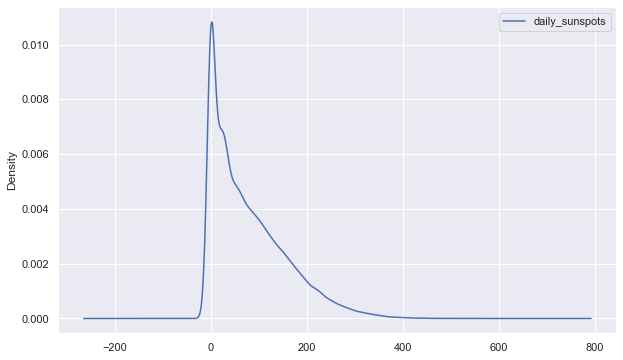

In [42]:
acf.plot.kde()

TypeError: can only concatenate str (not "int") to str